# BGM FASt implementation in SPACIOUS
## Deriving Galactic parameters from Gaia color-magnitude diagram

### Imports
#### General imports

In [1]:
import numpy as np
import time, sys, matplotlib, ast, math, re
import pandas as pd
from datetime import datetime
from pyspark.accumulators import AccumulatorParam
from pyspark.sql.functions import round as spark_round, col, log10, sin, cos, radians
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.integrate as integrate
import warnings
warnings.filterwarnings("ignore")

#### Spark-related imports and configuration

In [2]:
from spark_setup import SparkSetup
from setup_data_gaia_dr3 import SetupDataGaiaDR3
spark_setup = SparkSetup(pods=190, cpu=2, mem=17, data_setup=SetupDataGaiaDR3)
spark_gaia = spark_setup.get_spark_session()
sc = spark_gaia.sparkContext

Beginning the initilization of a spark cluster with 190 pods, 2 cores/pod and 17g mem/pod


25/12/09 09:39:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/09 09:39:24 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


Completed initialisation
Setting up SparkSQL
Setting up dataset Gaia DR3 with 4 databases gaiadr3, gaiadr3ssd, gaiaedr3ssd, gaiaedr3
Read default database gaiadr3ssd from environment config


### Functions definition
#### Spark accumulators functions

In [3]:
class MatrixAccumulatorParam(AccumulatorParam):

    '''
    Define a matrix accumulator of 4 dimensions

    Input parameters
    ----------------
    AccumulatorParam : pyspark.accumulators.AccumulatorParam --> Pyspark parameter needed for the definition of Pyspark accumulator matrixs
    '''

    def zero(self, inimatriu):
        '''
        Define a matrix of full of zeros

        Input parameters
        ----------------
        inimatriu : numpy array --> numpy array with the shape we want for the Pyspark accumulator

        Output parameters
        -----------------
        MATRIXINI : numpy array --> numpy array with the shape we want for the Pyspark accumulator full of zeros
        '''

        MATRIXINI = np.zeros(inimatriu.shape)

        return MATRIXINI


    def addInPlace(self, mAdd, sindex):
        '''
        Add an element to the accumulator in a given place

        Input parameters
        ----------------
        mAdd : Pyspark accumulator? --> accumulator into which we want to add an element
        sindex : list --> list with one or five elements containing the coordinates in the 4-dimensional (variable 1, variable 2, G-Rp and M_G') space of the Pyspark accumulator into which we want to put the element. The last element defines the value of the weight we want to add in that coordinates

        Output parameters
        -----------------
        mAdd : Pyspark accumulator? --> updated mAdd
        '''

        if type(sindex)==list:
            mAdd[sindex[0], sindex[1], sindex[2], sindex[3]] += sindex[4]
        else:
            mAdd += sindex

        return mAdd


def accumulators_init(sc, MatrixAccumulatorParam):

    '''
    Initialize one 4-dimensional and one 2-dimensional Pyspark accumulators with nvar1bins times nvar2bins times nColorbins times nGbins bins, and nMassbins times nTaubins bins, respectively

    Output parameters
    -----------------
    acc : pyspark accumulator --> 4-dimensional Pyspark accumulator (Hess diagram + variable 1 + variable 2) containing the Hess diagram
    simple : pyspark accumulator --> Pyspark simple accumulator that counts the stars that are not within the considered ranges or that have suffered some problem during the computations
    '''
    
    nvar1bins, nvar2bins = 1, 1, 
    nColorbins = math.ceil((2.5 - (-0.5))/0.05)
    nGbins = math.ceil((8.5 - (-5))/0.1)
    
    MATRIXCMD = np.zeros((nvar1bins, nvar2bins, nColorbins, nGbins))

    acc = sc.accumulator(MATRIXCMD, MatrixAccumulatorParam())
    simple = sc.accumulator(0)

    return acc, simple


def return_cmd(acc):

    '''
    Return the accumulators and obtain the variable with the two accumulators appended

    Output parameters
    -----------------
    MATRIXCMD : numpy array --> 4-dimensional numpy array (Hess diagram + variable 1 + variable 2) containing the complete Hess diagram
    data : numpy array --> 4-dimensional numpy array with the Hess diagrams corresponding to each one of the variable 1 and variable 2 ranges
    '''

    MATRIXCMD = acc.value
    data = np.reshape(acc.value, np.size(acc.value))

    return MATRIXCMD, data

#### BGM FASt auxiliary functions

In [26]:
# ************************************
# BGM FAST weight computation function
# ************************************

def Simplified_Gi_Primal_func_NONP(itau, smass, K1, K2, K3, alpha1, alpha2, alpha3, SigmaBFParam, bin_nor):

    '''
    Computation of the numerator or the denominator of Equation (37) from Mor et al. 2018. Sigma_all/bin_nor is exactly Sigma_primal. This computation corresponds to a single star and it is used to obtain the weight of that star.

    Input parameters
    ----------------
    itau : int --> index corresponding to the subpopulation (itau = popbin - 1)
    smass : int or float --> mass of the star
    K1 : int or float --> first continuity coeficient of the IMF
    K2 : int or float --> second continuity coeficient of the IMF
    K3 : int or float --> third continuity coeficient of the IMF
    alpha1 : int or float --> first slope (alpha) of the IMF
    alpha2 : int or float --> second slope (alpha) of the IMF
    alpha3 : int or float --> third slope (alpha) of the IMF
    SigmaBFParam : list --> surface density at the position of the Sun for the different age subpopulations for BGM FASt
    bin_nor : int or float --> normalization coeficient for binaries

    Output parameters
    -----------------
    integralout : float --> numerator or denominator of Eq. (37) from Mor et al. 2018 for a given star
    '''

    x1, x2, x3 = 0.015, 0.5, 1.53
    
    imassmin = smass
    imassmax = smass + 0.025

    if x1<=smass<x2:
        imf = (K1*(imassmax**(-alpha1 + 2) - ((imassmin)**(-alpha1 + 2)))/(-alpha1 + 2))
    elif x2<=smass<=x3:
        imf = (K2*(imassmax**(-alpha2 + 2) - ((imassmin)**(-alpha2 + 2)))/(-alpha2 + 2))
    elif smass>x3:
        imf = (K3*(((imassmax)**(-alpha3 + 2)) - ((imassmin)**(-alpha3 + 2)))/(-alpha3 + 2))

    # Notice the result is divided by bin_nor as Sigma_all/bin_nor is Sigma_primal
    integralout = (SigmaBFParam[itau])*imf/bin_nor

    return integralout


# ***********************************
# IMF continuity coeficients function
# ***********************************

def Continuity_Coeficients_func(alpha1, alpha2, alpha3):

    '''
    Compute the continuity coeficients of the Initial Mass Function (IMF), which we describe as a three-trunkated power law. We are looking for the coeficients that will let us have continuity in the IMF by applying the normalization stated next to Eq. (30) in Mor et al. 2018. Therefore, the three conditions we apply to find them are: normalization, continuity in x2 and continuity in x3. Applying these conditions we can find the functions that are used to compute the continuity coeficients. 

    Input parameters
    ----------------
    alpha1 : int or float --> first slope (alpha) of the IMF
    alpha2 : int or float --> second slope (alpha) of the IMF
    alpha3 : int or float --> third slope (alpha) of the IMF

    Output parameters
    -----------------
    K1 : float --> first continuity coeficient
    K2 : float --> second continuity coeficient
    K3 : float --> third continuity coeficient
    '''

    x1, x2, x3, x4 = 0.015, 0.5, 1.53, 120

    # We use one equation for each IMF slope, f1,f2,f3.
    f1 = lambda m: m**(-alpha1)*m
    f2 = lambda m: m**(-alpha2)*m
    f3 = lambda m: m**(-alpha3)*m

    # Integration and computation of the Continuity Coeficients
    I1 = integrate.quad(f1, x1, x2)
    I2 = integrate.quad(f2, x2, x3)
    I3 = integrate.quad(f3, x3, x4)

    K1K2=x2**(-alpha2 + alpha1)
    K2K3=x3**(-alpha3 + alpha2)

    K1 = 1/(I1[0] + 1/K1K2*I2[0] + 1/(K1K2*K2K3)*I3[0])
    K2 = K1/K1K2
    K3 = K1/(K1K2*K2K3)

    return K1, K2, K3


# ********************************************
# Binaries probabilities computation functions
# ********************************************

def Omega_func_aux2(taumax, taumin, m):

    '''
    Computation of the auxiliary function needed to compute the Omega function. The expressions for the age limit given the mass are fitted to the stellar evolutionary tracks inculded in Besançon Galaxy Model (Czekaj, et al. 2014) and Bertelli et al. 2008.

    Input parameters
    ----------------
    taumax : int or float --> upper limit of the age subpopulation interval in years
    taumin : int or float --> lower limit of the age subpopulation interval in years
    m : int or float --> mass of the star

    Output parameters
    -----------------
    omega : float --> auxiliari value needed for later computations
    '''

    if (m>20):
        taulim = np.exp(-0.61533562*np.log(m)+17.85867643) # New after sumbitting the paper
    elif (7<=m<=20): # Equation (53) from Mor et al. 2018
        taulim = np.exp(-1.57703799*np.log(m)+20.77243055) # tau limit is the maximum age of a star given its mass
    elif (2.2<m<7):
        taulim = np.exp(-2.72386552*np.log(m)+23.0181053) # Equation (54) from Mor et al. 2018
    elif (2<m<2.2):
        taulim = np.exp(-2.72386552*np.log(2.2)+23.0181053)   # Equation (55) from Mor et al. 2018
    elif (m<=2):
        taulim = np.exp(-3.44517144*np.log(m)+23.26518166) # Equation (56) from Mor et al. 2018

    # The next piece of code is the Equation (57) from Mor et al. 2018
    if (taulim>=taumax) :
        omega = 1
    elif (taulim<=taumin) :
        omega = 0
    else:
        omega = (taulim - taumin)/(taumax - taumin)

    return omega


def Omega_func(m, itau, tau_edges):

    '''
    Computation of Equation (57) from Mor et al. 2018. We define one Omega function for each thin disc age sub-population of the BGM. See Robin et al. 2003, Mor et al. 2017 to get the used age limits for each interval.

    Input parameters
    ----------------
    m : int or float --> mass of the star
    itau : int --> index corresponding to the subpopulation (itau = popbin - 1). In case ThickParamYoung=='fit' and itau==7, itau is set to 0
    tau_edges : list --> limits of the age subpopulations intervals

    Output parameters
    -----------------
    Omega_interv : float --> exactly omega (see description in Omega_func_aux2 function)
    '''
    
    taumin, taumax = [tau*10**9 for tau in tau_edges[itau]]
    Omega_interv = Omega_func_aux2(taumax, taumin, m)

    return Omega_interv


def prob_M_m_func(m, x1):

    '''
    Computation of the probability to obtain a secondary star of mass m given a primary of mass M. We approximate this probability as a uniform distribution between x1 (the adopted minimum mass for the BGM thin disc from Czekaj et al. 2014) and M (the mass of the primary component). This is part of Equation (48) from Mor et al. 2018

    Input parameters
    ----------------
    m : int or float --> mass of the star
    x1 : int or float --> minimum mass to generate a star

    Output parameters
    -----------------
    prob_M_m : float --> value of the probability mentioned in the description
    '''

    prob_M_m = 1/(m - x1)

    return prob_M_m


def int_prob_M_m_func(m, x1):

    '''
    Computation of the integral corresponding to the probabilities defined in the description of the prob_M_m_func function

    Input parameters
    ----------------
    m : int or float --> mass of the star
    x1 : int or float --> minimum mass to generate a star

    Output parameters
    -----------------
    I1_M_m : float --> value of the integral mentioned in the description
    '''

    f_M_m = lambda M: prob_M_m_func(m, x1)*M
    I1_M_m = integrate.quad(f_M_m, x1, m)[0]

    return I1_M_m


def bin_prob_func(M1):

    '''
    Computation of the probability that a star of mass M1 belongs to a multiple system. This is part of the implementaiton of Equation (49) from Mor et al. 2018. This expression of the probability is taken directly from the BGM Standard code and defers a bit from the expression in the Arenou's paper. This is the expression of Frederic Arenou for the main sequence stars. For the moment we assume that all stars have this pdf. Maybe later we can think how we can introduce the 60% forced for Giants.

    Input parameters
    ----------------
    M1 : int or float --> mass of the star

    Output parameters
    -----------------
    bin_Prob : float --> value of the probability mentioned in the description
    '''

    bin_Prob = 0.85*np.tanh(0.55*M1 + 0.095)

    return bin_Prob


def f_toint1_func3_NONP(itau, K1, K2, K3, alpha1, alpha2, alpha3, SigmaParam):

    '''
    Computation of the binarity normalization term. From Equation (31) from  Mor et al. 2018 one can write Sigma_all=Sigma_primals+Sigma_Secondaries; Sigma_Secondaries=Sigma_primal*Term, then Sigma_all=Sigma_primals*(1+Term); This function gives us Term for a given subpopulation. Its formulation comes from Equation (52) from Mor et al. 2018 dividing both sides by Sigma_primal. In this case, we compute the binarity normalization term for a non-parametric SFH.

    Input parameters
    ----------------
    itau : int --> index corresponding to the subpopulation (itau = popbin - 1)
    x1 : int or float --> minimum mass to generate a star
    x2 : int or float --> first mass limit of the IMF
    x3 : int or float --> second mass limit of the IMF
    x4 : int or float --> maximum mass of a star
    K1 : int or float --> first continuity coeficient of the IMF
    K2 : int or float --> second continuity coeficient of the IMF
    K3 : int or float --> third continuity coeficient of the IMF
    alpha1 : int or float --> first slope (alpha) of the IMF
    alpha2 : int or float --> second slope (alpha) of the IMF
    alpha3 : int or float --> third slope (alpha) of the IMF
    SigmaParam : list --> surface density at the position of the Sun for the different age subpopulations
    tau_edges : list --> limits of the age subpopulations intervals

    Output parameters
    -----------------
    integralout : float --> value of the normalization term of the given subpopulation
    '''

    x1, x2, x3, x4 = 0.015, 0.5, 1.53, 120
    tau_edges = [[0, 0.15], [0.15, 1], [1, 2], [2, 3], [3, 5], [5, 7], [7, 10]]
    
    f1 = lambda m:m**(-alpha1)*Omega_func(m, itau, tau_edges)*bin_prob_func(m)*int_prob_M_m_func(m, x1)
    f2 = lambda m:m**(-alpha2)*Omega_func(m, itau, tau_edges)*bin_prob_func(m)*int_prob_M_m_func(m, x1)
    f3 = lambda m:m**(-alpha3)*Omega_func(m, itau, tau_edges)*bin_prob_func(m)*int_prob_M_m_func(m, x1)

    I1_s = integrate.quad(f1,x1,x2)
    I2_s = integrate.quad(f2,x2,x3)
    I3_s = integrate.quad(f3,x3,x4)

    integral = K1*I1_s[0] + K2*I2_s[0] + K3*I3_s[0]
    integralout = (SigmaParam[itau]/sum(SigmaParam))*integral

    return integralout


def bin_nor_func(K1, K2, K3, alpha1, alpha2, alpha3, SigmaParam):

    '''
    Computation of the normalization due to secondary (binary) stars. See complemetary information in the description of f_toint1_func3_NONP function

    Input parameters
    ----------------
    K1 : int or float --> first continuity coeficient of the IMF
    K2 : int or float --> second continuity coeficient of the IMF
    K3 : int or float --> third continuity coeficient of the IMF
    alpha1 : int or float --> first slope (alpha) of the IMF
    alpha2 : int or float --> second slope (alpha) of the IMF
    alpha3 : int or float --> third slope (alpha) of the IMF
    SigmaParam : list --> surface density at the position of the Sun for the different age subpopulations

    Output parameters
    -----------------
    bin_nor : float --> value of the normalization term
    '''
    
    binarity_norm = []
    for i in range(len(SigmaParam)):
            binarity_norm.append(f_toint1_func3_NONP(i, K1, K2, K3, alpha1, alpha2, alpha3, SigmaParam))

    bin_nor = sum(binarity_norm) + 1.

    return bin_nor


# *******************
# Auxiliary functions
# *******************

def define_SigmaBFParam(SigmaParam):
    
    '''
    Compute SigmaBFParam as a function of SigmaParam, tau_edges, and tau_ranges assuming a flat value of the SFH in each BGM Std SFH bin. This function is mainly to compute SigmaBFParam_ms from SigmaParam.
    
    Input parameters
    ----------------
    SigmaParam : numpy array --> surface density at the position of the Sun for the different age subpopulations of the thin/thick disc for the MS
    
    Output parameters
    -----------------
    SigmaBFParam : numpy array --> surface density at the position of the Sun for the different age subpopulations of the thin/thick disc for the BGM FASt
    '''

    tau_edges = [[0, 0.15], [0.15, 1], [1, 2], [2, 3], [3, 5], [5, 7], [7, 10]]
    tau_ranges = [[0, 0.15], [0.15, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10]]
    
    SigmaBFParam = []
    for r_start, r_end in tau_ranges:
        for i, (e_start, e_end) in enumerate(tau_edges):
            if e_start<=r_start and e_end>=r_end:
                SigmaBFParam.extend([SigmaParam[i]/(e_end - e_start)*(r_end - r_start)])
                break
        else:
            raise ValueError(f"Fine bin [{r_start}, {r_end}] does not fall into any coarse bin!")

    return np.array(SigmaBFParam)


def recover_SigmaParam(SigmaBFParam):
    
    '''
    Compute SigmaParam as a function of SigmaBFParam, tau_edges, and tau_ranges. This function is mainly to compute SigmaParam_ps from SigmaBFParam.
    
    Input parameters
    ----------------
    SigmaBFParam : numpy array --> surface density at the position of the Sun for the different age subpopulations of the thin/thick disc for BGM FASt
    
    Output parameters
    -----------------
    SigmaParam : numpy array --> surface density at the position of the Sun for the different age subpopulations of the thin/thick disc for BGM Std
    '''

    tau_edges = [[0, 0.15], [0.15, 1], [1, 2], [2, 3], [3, 5], [5, 7], [7, 10]]
    tau_ranges = [[0, 0.15], [0.15, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10]]
    
    SigmaParam = [0]*len(tau_edges)
    for i, (e_start, e_end) in enumerate(tau_edges):
        for j, (r_start, r_end) in enumerate(tau_ranges):
            if r_start>=e_start and r_end<=e_end:
                SigmaParam[i] += SigmaBFParam[j]
        
    return np.array(SigmaParam)


# ****************************************
# Binning color-magnitude diagram function
# ****************************************

def binning_4D_Mvarpi(S):

    '''
    Compute the position of a give star in bins in the discretized space of the 4-dimensional (variable 1, variable 2, G-Rp colour and absolute magnitude) accumulators

    Input parameters
    ----------------
    S : list [var1, var2, G-Rp, M_G'] --> variable 1, variable 2, colour, and absolute magnitude of the star

    Output parameters
    -----------------
    Ivar1S : int --> bin number in the variable 1 discretized space
    Ivar2S : int --> bin number in the variable 2 discretized space
    IXS : int --> bin number in the G-Rp discretized space
    IYS : int --> bin number in the M_G' discretized space
    '''

    var1S = float(S[0]) # variable 1
    var2S = float(S[1]) # variable 2
    XS = float(S[2]) # Color G-Rp
    YS = float(S[3]) # M_G' magnitude
    rstar = float(S[4]) # distance

    # Checking that the values are inside the desired limits
    if (-5<=var1S<=5 and 0<=var2S<=360 and -0.5<=XS<2.5 and -5<=YS<8.5 and 0<=rstar<=50000):
        Ivar1S = 0
        Ivar2S = 0
        IXS = int((XS - (-0.5))/0.05)
        IYS = int((YS - (-5))/0.1)

    # Giving a value for this stars which is not in the desired ranges
    else:
        Ivar1S = np.nan
        Ivar2S = np.nan
        IXS = np.nan
        IYS = np.nan

    return Ivar1S, Ivar2S, IXS, IYS

#### BGM FASt weigths computation functions

In [27]:
def pes_catalog(x, acc, simple):

    '''
    Build the Hess diagram of the observed catalog using a Pyspark accumulator

    Input parameters
    ----------------
    x : list --> each one of the rows in the Mother Simulation file
    acc : pyspark accumulator --> 4-dimensional Pyspark accumulator (Hess diagram + variable 1 + variable 2) containing the complete Hess diagram
    simple : pyspark accumulator --> Pyspark simple accumulator that counts the stars that are not within the considered ranges or that have suffered some problem during the computations

    Output parameters
    -----------------
    cpes : int --> weight of the star. In this case, since we are dealing with the observed data, the value of the weight is always 1
    '''

    GRp = float(x[1])
    var1 = float(x[2])
    var2 = float(x[3])
    Mvarpi = float(x[4])
    parallax = float(x[5])
    rstar = 1/parallax*1000.

    xinput = [var1, var2, GRp, Mvarpi, rstar]
    matindex = binning_4D_Mvarpi(xinput)

    cpes=1

    if (np.isnan(matindex[0]) or np.isnan(matindex[1]) or np.isnan(matindex[2]) or np.isnan(matindex[3])):
        simple.add(1)
    else:
        acc.add([int(matindex[0]), int(matindex[1]), int(matindex[2]), int(matindex[3]), cpes])

    return cpes


def wpes_func(x, K1_ps, K2_ps, K3_ps, alpha1_ps, alpha2_ps, alpha3_ps, SigmaBFParam_ps, bin_nor_ps, K1_ms, K2_ms, K3_ms, alpha1_ms, alpha2_ms, alpha3_ms, SigmaBFParam_ms, bin_nor_ms, acc):

    '''
    Compute the weight of a given mass-age bin and assign it to all the stars within the bin. It uses Equation (37) from Mor et al. 2018 without integrating. The integral is conceptual, because it defines the integration over an increment (bin) of the N-dimensional space defined in Eq. (6). We reduce this increment until the end, when we only consider the star itself. At that point, the increment is exactly equal to the differential (both of them are the star itself) and the integral blows up.

    Input parameters
    ----------------
    WP : list --> a row of the mother simulation dataframe
    K1_ps : int or float --> first continuity coeficient of the IMF for the BGM FASt simulation
    K2_ps : int or float --> second continuity coeficient of the IMF for the BGM FASt simulation
    K3_ps : int or float --> third continuity coeficient of the IMF for the BGM FASt simulation
    alpha1_ps : int or float --> first slope (alpha) of the IMF for the BGM FASt simulation
    alpha2_ps : int or float --> second slope (alpha) of the IMF for the BGM FASt simulation
    alpha3_ps : int or float --> third slope (alpha) of the IMF for the BGM FASt simulation
    SigmaBFParam_ps : list --> surface density at the position of the Sun for the different age subpopulations of the thin disc for BGM FASt for the BGM FASt simulation. In case ThickParamYoung=='fit', SigmaBFParam_ps is a list with SigmaBFParam_ps and T_SigmaBFParam_ps
    bin_nor_ps : int or float --> normalization coeficient for binaries for the BGM FASt simulation. In case ThickParamYoung=='fit', bin_nor_ps is a list with bin_nor_ps and T_bin_nor_ps
    K1_ms : int or float --> first continuity coeficient of the IMF for the Mother Simulation
    K2_ms : int or float --> second continuity coeficient of the IMF for the Mother Simulation
    K3_ms : int or float --> third continuity coeficient of the IMF for the Mother Simulation
    alpha1_ms : int or float --> first slope (alpha) of the IMF for the Mother Simulation
    alpha2_ms : int or float --> second slope (alpha) of the IMF for the Mother Simulation
    alpha3_ms : int or float --> third slope (alpha) of the IMF for the Mother Simulation
    SigmaBFParam_ms : list --> surface density at the position of the Sun for the different age subpopulations of the thin disc for BGM FASt. In case ThickParamYoung=='fit', SigmaBFParam_ms is a list with SigmaBFParam_ms and T_SigmaBFParam_ms
    bin_nor_ms : int or float --> normalization coeficient for binaries for the Mother Simulation. In case ThickParamYoung=='fit', bin_nor_ms is a list with bin_nor_ms and T_bin_nor_ms
    acc : pyspark accumulator --> 4-dimensional Pyspark accumulator (Hess diagram + variable 1 + variable 2) containing the complete Hess diagram

    Output parameters
    -----------------
    wpes : int --> weight of the star derived from BGM FASt
    '''

    wpes = 1
    GRp = float(x[1])
    var1 = float(x[2])
    var2 = float(x[3])
    Mvarpi = float(x[4])
    parallax = float(x[5])
    rstar = 1/parallax*1000.
    popbin = float(x[6]) # BGM population bin
    mass = float(x[7]) # Mass of the star
    tau = float(x[8]) # Age of the star

    tranges = [[0, 0.15], [0.15, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10]]

    if popbin<=7: 
        for i, (tau_min, tau_max) in enumerate(tranges):
            if tau_min<=tau<=tau_max:
                itau = i
                break
        else:
            itau = np.nan

    if popbin<=7:

        PS = float(Simplified_Gi_Primal_func_NONP(itau, mass, K1_ps, K2_ps, K3_ps, alpha1_ps, alpha2_ps, alpha3_ps, SigmaBFParam_ps, bin_nor_ps))

        MS = float(Simplified_Gi_Primal_func_NONP(itau, mass, K1_ms, K2_ms, K3_ms, alpha1_ms, alpha2_ms, alpha3_ms, SigmaBFParam_ms, bin_nor_ms))

        if PS==0:
            wpes = 0
        elif MS==0:
            wpes = 1
        else:
            wpes = PS/MS

    elif popbin in (8, 9, 10, 11):
        wpes = 1
        
    else:
        print('Not correct popbin %i or age %f' %(popbin, tau))
        import sys
        sys.exit()

    xinput = [var1, var2, GRp, Mvarpi, rstar]
    matindex = binning_4D_Mvarpi(xinput)
    
    if (np.isnan(matindex[0]) or np.isnan(matindex[1]) or np.isnan(matindex[2]) or np.isnan(matindex[3])):
        pass
    else:
        acc.add([int(matindex[0]), int(matindex[1]), int(matindex[2]), int(matindex[3]), wpes])
        
    return wpes

#### Distance and CMD plots functions

In [23]:
def compute_bin_quotient(H_t_bin, H0_bin, thresh):
    '''
    Compute the quotient in a given bin of two Hess diagrams
    
    Input parameters
    ----------------
    H_t_bin : int or float --> number of counts in the given catalog bin
    H0_bin : int or float --> number of counts in the given simulation bin
    thresh : int or float --> minimum threshold for the number of stars per bin in the catalog to consider that bin for the computation of the distance. Set the threshold to -1 to deactivate the threshold
    
    Output parameters
    -----------------
    quot_bin : float --> quotient in the bin between the catalog and the simulation
    '''
    
    if H_t_bin<thresh:
        quot_bin = 1
    elif H_t_bin==0 or H0_bin==0:
        quot_bin = (H0_bin + 1)/(H_t_bin + 1)
    else:
        quot_bin = H0_bin/H_t_bin
    
    return quot_bin


def compute_bin_distance(H_t_bin, H0_bin, thresh):
    
    '''
    Compute the distance metric in a given bin of two Hess diagrams
    
    Input parameters
    ----------------
    H_t_bin : int or float --> number of counts in the given catalog bin
    H0_bin : int or float --> number of counts in the given simulation bin
    thresh : int or float --> minimum threshold for the number of stars per bin in the catalog to consider that bin for the computation of the distance. Set the threshold to -1 to deactivate the threshold
    
    Output parameters
    -----------------
    dist_bin : float --> distance in the bin between the catalog and the simulation
    '''
    
    if H_t_bin<thresh:
        dist_bin = 0
    elif H_t_bin==0 or H0_bin==0:
        R_bin = compute_bin_quotient(H_t_bin, H0_bin, thresh)
        dist_bin = (H_t_bin + 1)*(1 - R_bin + np.log(R_bin)) 
    else:
        R_bin = compute_bin_quotient(H_t_bin, H0_bin, thresh)
        dist_bin = H_t_bin*(1 - R_bin + np.log(R_bin))
    
    return dist_bin
    

def generate_difference_hess_diagram(catalog1_cmd, catalog2_cmd, thresh):
    '''
    Crossmatch two catalogs and analyze differences
    
    Input parameters
    ----------------
    catalog1_cmd : numpy array --> 4-dimensional numpy array (Hess diagram + variable 1 + variable 2) containing the complete Hess diagram of the first catalog
    catalog2_cmd : numpy array --> 4-dimensional numpy array (Hess diagram + variable 1 + variable 2) containing the complete Hess diagram of the second catalog
    Note: when comparing simulations and observed data, catalog 1 refers to the simulation and catalog 2 to the data according to Eq. (58) from Mor et al. 2018 for the computation of the distance. 
    
    Output parameters
    -----------------
    distance_cmd : numpy array --> 4-dimensional numpy array (Hess diagram + variable 1 + variable 2) containing the distance per bin of the complete Hess diagrams between catalogs
    difference_cmd : numpy array --> 4-dimensional numpy array (Hess diagram + variable 1 + variable 2) containing the absolute difference in number of stars per bin of the complete Hess diagrams between catalogs
    quocient_cmd : numpy array --> 4-dimensional numpy array (Hess diagram + variable 1 + variable 2) containing the quocient of the number of stars per bin of the complete Hess diagrams between catalogs
    
    '''
    
    quocient_cmd = np.array([[[[compute_bin_quotient(catalog2_cmd[var1][var2][i][j], catalog1_cmd[var1][var2][i][j], thresh) for j in range(len(catalog1_cmd[var1][var2][i]))] for i in range(len(catalog1_cmd[var1][var2]))] for var2 in range(len(catalog1_cmd[var1]))] for var1 in range(len(catalog1_cmd))])
    
    distance_cmd = np.array([[[[compute_bin_distance(catalog2_cmd[var1][var2][i][j], catalog1_cmd[var1][var2][i][j], thresh) for j in range(len(quocient_cmd[var1][var2][i]))] for i in range(len(quocient_cmd[var1][var2]))] for var2 in range(len(quocient_cmd[var1]))] for var1 in range(len(quocient_cmd))])
    
    difference_cmd = catalog1_cmd - catalog2_cmd
    
    return distance_cmd, difference_cmd, quocient_cmd


def build_hess_diagrams_plots(catalog1_cmd, catalog2_cmd, distance_cmd, difference_cmd, thresh, output=False, show=True, titles=['Catalog 1', 'Catalog 2', r'$\delta_P$(Catalog 1, Catalog 2)', 'Catalog 1 - Catalog 2'], limits='auto'):
    '''
    Build the Hess diagrams of two catalogs and their differences
    
    Input parameters
    ----------------
    catalog1_cmd : numpy array --> 4-dimensional numpy array (Hess diagram + variable 1 + variable 2) containing the complete Hess diagram of the first catalog
    catalog2_cmd : numpy array --> 4-dimensional numpy array (Hess diagram + variable 1 + variable 2) containing the complete Hess diagram of the second catalog
    Note: when comparing simulations and observed data, catalog 1 refers to the simulation and catalog 2 to the data according to Eq. (58) from Mor et al. 2018 for the computation of the distance
    distance_cmd : numpy array --> 4-dimensional numpy array (Hess diagram + variable 1 + variable 2) containing the distance per bin of the complete Hess diagrams between catalogs
    difference_cmd : numpy array --> 4-dimensional numpy array (Hess diagram + variable 1 + variable 2) containing the absolute difference in number of stars per bin of the complete Hess diagrams between catalogs
    output : str or False --> directory of the output file of the plot
    show : boolean --> wether you want the plot to be displayed or not
    titles : list --> titles of the four different columns of the plot
    limits : list or 'auto' --> upper limits of the plots in each one of the four colour bars or set to 'auto'
    '''

    dist_threshold = thresh

    nvar1bins = 1
    nvar2bins = 1
    Xmin = -0.5
    Xmax = 2.5
    Ymin = -5
    Ymax = 8.5

    extent = [Xmin, Xmax, Ymax, Ymin]

    fig = plt.figure(figsize=(2 + 5*len(titles), 4*nvar1bins))
    fig.tight_layout()
    axs = fig.subplots(nvar1bins, len(titles), gridspec_kw={'width_ratios': [1, 1, 1.25, 1.25]})

    if limits=='auto':
        limits_hess = max(np.array(catalog1_cmd).max(), np.array(catalog2_cmd).max())
        limits_dist = max([abs(np.quantile(distance_cmd, 0.01)), abs(np.quantile(distance_cmd, 0.99))])
        limits_diff = max([abs(np.quantile(difference_cmd, 0.01)), abs(np.quantile(difference_cmd, 0.99))])
    else:
        if limits[0]=='auto':
            limits_hess = max(np.array(catalog1_cmd).max(), np.array(catalog2_cmd).max())
        else:
            limits_hess = limits[0]
        if limits[1]=='auto':
            limits_dist = max([abs(np.quantile(distance_cmd, 0.01)), abs(np.quantile(distance_cmd, 0.99))])
        else:
            limits_dist = limits[1]
        if limits[2]=='auto':
            limits_diff = max([abs(np.quantile(difference_cmd, 0.01)), abs(np.quantile(difference_cmd, 0.99))])
        else:
            limits_diff = limits[2] 

    for var1 in range(nvar1bins):
        for var2 in range(nvar2bins):
            for col in range(len(titles)):

                if var1==0:
                    if nvar1bins>1:
                        axs[var1, col].set_title(titles[col])
                    else:
                        axs[col].set_title(titles[col])

                if col==0:
                    if nvar1bins>1:
                        axs[var1, col].set_ylabel(r"$M_G'$")
                    else:
                        axs[col].set_ylabel(r"$M_G'$")

                if (var1 + 1)==nvar1bins:
                    if nvar1bins>1:
                        axs[var1, col].set_xlabel("$G-Rp$")
                    else:
                        axs[col].set_xlabel("$G-Rp$")

                cmap = plt.cm.jet
                cmap.set_bad(color="white")

                cmap2 = matplotlib.colormaps.get_cmap('gist_stern').reversed()
                
                #cmap2 = matplotlib.colormaps.get_cmap('terrain').reversed()
                #cmap2 = matplotlib.colormaps.get_cmap('gist_earth').reversed()
                cmap2.set_bad(color="white")

                cmap3 = matplotlib.colormaps.get_cmap('RdYlGn')
                cmap3.set_bad(color='white')
                
                if nvar1bins>1:
                    axs[var1, col].set_xlim(Xmin, Xmax)
                    axs[var1, col].set_ylim(Ymax, Ymin)
                else:
                    axs[col].set_xlim(Xmin, Xmax)
                    axs[col].set_ylim(Ymax, Ymin)
                if col==0:
                    CMD = np.log10(catalog1_cmd[var1][var2]).T
                    norm_hess = colors.Normalize(vmin=np.log10(dist_threshold), vmax=np.log10(limits_hess))
                    if nvar1bins>1:
                        hess_catalog = axs[var1, col].imshow(CMD, extent=extent, interpolation="nearest", cmap=cmap, aspect="auto", norm=norm_hess)
                    else:
                        hess_catalog = axs[col].imshow(CMD, extent=extent, interpolation="nearest", cmap=cmap, aspect="auto", norm=norm_hess)
                    hess_catalog.set_clim(np.log10(dist_threshold), np.log10(limits_hess))

                elif col==1:
                    CMD = np.log10(catalog2_cmd[var1][var2]).T
                    norm_hess = colors.Normalize(vmin=np.log10(dist_threshold), vmax=np.log10(limits_hess))
                    if nvar1bins>1:
                        hess_bgmfast = axs[var1, col].imshow(CMD, extent=extent, interpolation="nearest", cmap=cmap, aspect="auto", norm=norm_hess)
                    else:
                        hess_bgmfast = axs[col].imshow(CMD, extent=extent, interpolation="nearest", cmap=cmap, aspect="auto", norm=norm_hess)
                    hess_bgmfast.set_clim(np.log10(dist_threshold), np.log10(limits_hess))

                elif col==2:
                    CMD = abs(distance_cmd[var1][var2]).T
                    norm_sum = colors.Normalize(vmin=0, vmax=limits_dist)
                    if nvar1bins>1:
                        hess_sum = axs[var1, col].imshow(CMD, extent=extent, interpolation="nearest", cmap=cmap2, aspect="auto", norm=norm_sum)
                    else:
                        hess_sum = axs[col].imshow(CMD, extent=extent, interpolation="nearest", cmap=cmap2, aspect="auto", norm=norm_sum)
                    hess_sum.set_clim(0, limits_dist)

                elif col==3:
                    CMD = difference_cmd[var1][var2].T
                    CMD = np.ma.masked_where(CMD==0, CMD)
                    norm_diff = colors.Normalize(vmin=-limits_diff, vmax=limits_diff)
                    if nvar1bins>1:
                        hess_diff = axs[var1, col].imshow(CMD, extent=extent, interpolation="nearest", cmap=cmap3, aspect="auto", norm=norm_diff)
                    else:
                        hess_diff = axs[col].imshow(CMD, extent=extent, interpolation="nearest", cmap=cmap3, aspect="auto", norm=norm_diff)
                    hess_diff.set_clim(-limits_diff, limits_diff)

        cax = fig.add_axes([0.065, 0.130, 0.015, 0.75])
        cb = fig.colorbar(hess_bgmfast, cax=cax, norm=norm_hess)
        cb.set_label(r"$\log(N_\star)$")
        cax.yaxis.set_label_position("left")
        cax.yaxis.set_ticks_position("left")
        
        if nvar1bins>1:
            cb2 = fig.colorbar(hess_sum, ax=axs[:, 2], norm=norm_sum, aspect=30)
        else:
            cb2 = fig.colorbar(hess_sum, ax=axs[2], norm=norm_sum, aspect=30)
        #cb2.set_label(r"$q|1 - R + \ln(R)|$")
        
        if nvar1bins>1:
            cb3 = fig.colorbar(hess_diff, ax=axs[:, 3], norm=norm_diff, aspect=30, ticklocation='left')
        else:
            cb3 = fig.colorbar(hess_diff, ax=axs[3], norm=norm_diff, aspect=30, ticklocation='left')
        #cb3.set_label(r"$N_\star$")

    if output!=False:
        fig.savefig(output, dpi=300)
    if show:
        plt.show()
    plt.close()


def dist_metric_gdaf2(H_t, HO, thresh):

    '''
    Computation of the distance metric to be used in the ABC code. We use the so-called Poissonian distance. The expression can be found in the Equation (58) from Mor et al. 2018.

    Input parameters
    ----------------
    H_t : 4-dimensional accumulator -->  catalog data in the 4-dimensional space (Hess diagram + variable 1 + variable 2) used as a summary statistics
    H0 : 4-dimensional accumulator --> simulation data in the 4-dimensional space (Hess diagram + variable 1 + variable 2) used as a summary statistics
    thresh : int or float --> minimum threshold for the number of stars per bin in the catalog to consider that bin for the computation of the distance. Set the threshold to -1 to deactivate the threshold

    Output parameters
    -----------------
    lrout : float --> value of the distance
    '''

    if HO.size==1:
        lrout = np.inf

    else:
        Lrb = [compute_bin_distance(i, j, thresh) for i,j in zip(H_t, HO)]

        lrout = np.abs(sum(Lrb))
        if np.isnan(lrout):
            lrout = np.inf

    return lrout


def compute_distance(catalog2_data, catalog1_data, thresh):
    '''
    Compute the metric distance between two catalogs
    
    Input parameters
    ----------------
    catalog1_data : numpy array --> catalog data in the 4-dimensional space (Hess diagram + variable 1 + variable 2) used as a summary statistics
    catalog2_data : numpy array --> catalog data in the 4-dimensional space (Hess diagram + variable 1 + variable 2) used as a summary statistics
    Note: when comparing simulations and observed data, catalog 1 refers to the simulation and catalog 2 to the data according to Eq. (58) from Mor et al. 2018 for the computation of the distance
    
    Output parameters
    -----------------
    distance : float --> value of the metric distance between the catalogs
    '''

    distance = dist_metric_gdaf2(catalog2_data, catalog1_data, thresh)
    print('\nDistance between catalogs: %f\n' %distance)

    return distance


def build_sfh_imf(tau_values, sfh_params, imf_ranges, imf_params, output=False, show=False, sfh_limits=[0, 13], imf_limits=[-1, 3]):
    """
    Build SFH and IMF plots side-by-side in a single figure.

    Parameters
    ----------
    tau_values : array
    sfh_params : array
    imf_ranges : array
    imf_params : array
    output : str or bool
        Path to save the figure, or False to disable saving.
    show : bool
        Whether to display the figure.
    sfh_limits : list
        [ymin, ymax] for the SFH panel.
    imf_limits : list
        [ymin, ymax] for the IMF panel.
    """

    fig, axes = plt.subplots(1, 2, figsize=(9, 3.75))

    # ---------------------------
    # Left panel: SFH
    # ---------------------------
    ax = axes[0]
    ax.errorbar(tau_values, sfh_params, fmt='o--',
                capsize=5, label='BGM FASt',
                color='blue', zorder=3)

    ax.set_xlim(0, 10)
    ax.invert_xaxis()
    ax.set_ylim(sfh_limits[0], sfh_limits[1])
    ax.set_xlabel('Age (Gyr)')
    ax.set_ylabel(r'Mean SFH per age bin ($M_\odot$/pc$^2$/Gyr)')
    ax.set_title("Star Formation History")

    # ---------------------------
    # Right panel: IMF
    # ---------------------------
    ax = axes[1]

    for i in range(len(imf_params)):
        x = np.linspace(imf_ranges[i], imf_ranges[i+1])
        ax.plot(x, np.full_like(x, imf_params[i]),
                linestyle='-', color='blue', zorder=3)

        # Divider lines
        if i < len(imf_params) - 1:
            ax.axvline(imf_ranges[i+1], alpha=0.5,
                       linestyle='--', color='black', linewidth=1)

    ax.set_xscale('log')
    ax.set_xlim(imf_ranges[0], imf_ranges[-1])
    ax.set_ylim(imf_limits[0], imf_limits[1])
    ax.set_xlabel(r'Stellar mass ($M/M_\odot$)')
    ax.set_ylabel(r'IMF slope $\alpha$')
    ax.set_title("Initial Mass Function")

    plt.tight_layout()

    # Save/show options
    if output:
        fig.savefig(output, dpi=300)
    if show:
        plt.show()
    plt.close()


### Gaia catalog
#### Gaia query: all stars within 100 pc with G<14

In [6]:
query= "SELECT phot_g_mean_mag, g_rp, ra, dec, l, b, parallax FROM gaiaedr3.gaia_source WHERE phot_g_mean_mag<14 AND parallax>10 AND parallax>0"
catalog_Gaia = spark_gaia.sql(query)
catalog_Gaia.show()

+---------------+----------+------------------+-------------------+------------------+-------------------+------------------+
|phot_g_mean_mag|      g_rp|                ra|                dec|                 l|                  b|          parallax|
+---------------+----------+------------------+-------------------+------------------+-------------------+------------------+
|       8.166432| 0.4400425| 53.83111812660465| 11.396688515318997|174.31825070281005| -34.65399736028976|10.254161606853724|
|      12.571564|0.93667126| 35.01290514668964| 18.486710477422854| 150.5784560172878|-39.580811635195914|11.994314766757787|
|      7.0066395| 0.4188528| 66.06128542553917| 21.736042245626578|174.82823835841563|-19.046341289877514|23.200912136413244|
|      13.913092| 1.1082182| 1.739349546191698|  45.03237296909148|114.73200874373744|-17.130005380435932|10.730315044980543|
|      10.494411| 0.8460903|15.768694753879577|  57.45458139284818|124.50343537416273| -5.381656409173985| 13.42255875

#### Filter null values and compute absolute magnitudes and Galactocentric coordinates

In [7]:
catalog_Gaia = catalog_Gaia.filter(col("parallax").isNotNull() & col("g_rp").isNotNull())
#zero_point_correction
catalog_Gaia = catalog_Gaia.withColumnRenamed("phot_g_mean_mag","G").withColumnRenamed("l","longitude").withColumnRenamed("g_rp","GRp").withColumnRenamed("b","latitude")
catalog_Gaia = catalog_Gaia.withColumn("Mvarpi", col("G") + 5 * log10(col("parallax") / 1000) + 5)
catalog_Gaia = catalog_Gaia.withColumn("z", 1/col("parallax")*sin(radians(col("latitude"))))
catalog_Gaia = catalog_Gaia.withColumn("r", 1/col("parallax")*cos(radians(col("latitude"))))
#remove_XMC
for column, dtype in catalog_Gaia.dtypes:
    if dtype in ["double", "float", "int", "bigint"]:
        catalog_Gaia = catalog_Gaia.withColumn(column, spark_round(col(column), 5))
sel_columns_Gaia = {'G':'G', 'color': 'GRp', 'var1': 'z', 'var2': 'longitude', 'Mvarpi': 'Mvarpi', 'parallax': 'parallax'}
catalog_Gaia = catalog_Gaia.select(list(sel_columns_Gaia.values()))

In [8]:
catalog_Gaia.count()

110373

### BGM mother simulation
#### Read mother simulation and filter by apparent magnitude

In [9]:
Gmax = 14.0
filename_BGM = 'ms2502_G14_err_noGC_100pc.csv'
catalog_BGM = pd.read_csv(filename_BGM)
catalog_BGM.head()
sel_columns_BGM = {'G':'Gerr', 'color': 'GRperr', 'var1': 'zerr', 'var2': 'longitude', 'Mvarpi': 'Mvarpi', 'parallax': 'parallaxerr', 'popbin': 'PopBin', 'mass': 'MassOut', 'age': 'Age'}
catalog_BGM = spark_gaia.createDataFrame(catalog_BGM).select(list(sel_columns_BGM.values()))
catalog_BGM = catalog_BGM.filter((catalog_BGM[sel_columns_BGM['G']]<float(Gmax)) & (catalog_BGM[sel_columns_BGM['parallax']]>float(0.0)))
catalog_BGM.show()

[Stage 4:>                                                          (0 + 1) / 1]

+--------+-------+-------+---------+-------+-----------+------+-------+------+
|    Gerr| GRperr|   zerr|longitude| Mvarpi|parallaxerr|PopBin|MassOut|   Age|
+--------+-------+-------+---------+-------+-----------+------+-------+------+
|  6.0244|0.25941|0.01443|  3.53801|2.20141|   17.19498|     2| 1.3587|0.2985|
|11.21243|0.91902|0.01121|  1.75146|7.83551|   21.11617|     3| 0.6028|1.3714|
| 6.12485|0.35258|0.01227|  0.49721|2.46912|   18.57184|     4| 1.5049|2.0113|
|10.79452| 0.8255|0.01263|  1.04126|7.14135|   18.59367|     7| 0.6681|9.2911|
| 9.08006|0.57597|0.00916|  1.14088|5.93802|   23.52836|     8| 0.6956|8.8536|
|11.82702|0.84204| 0.0187|  3.47358|7.34452|    12.6911|     1| 0.6707|0.1255|
| 5.16506| -0.077|0.01775|  2.51247|0.67239|   12.63183|     2| 2.7986|0.1542|
|13.02295|0.98623|0.01721|  3.61866|8.57788|   12.91179|     2| 0.5538|0.9728|
| 7.81966|0.32676|0.01721|    4.771|3.38928|   12.99941|     2| 1.3265|0.3802|
| 7.44251|0.32517| 0.0183|  2.65556| 2.9711|   12.75

In [10]:
catalog_BGM.count()

79690

### Run BGM FASt - compare Gaia and mother simulation

#### Generate Gaia CMD

In [11]:
acc, simple = accumulators_init(sc, MatrixAccumulatorParam)[:2]
catalog_Gaia.foreach(lambda x: pes_catalog(x, acc, simple))
catalog_cmd_Gaia, catalog_data_Gaia = return_cmd(acc)

#### Generate mother simulation CMD

In [12]:
acc, simple = accumulators_init(sc, MatrixAccumulatorParam)[:2]
catalog_BGM.foreach(lambda x: pes_catalog(x, acc, simple))
catalog_cmd_ms, catalog_data_ms = return_cmd(acc)

#### Compute distance and difference between Gaia and mother simulation CMDs

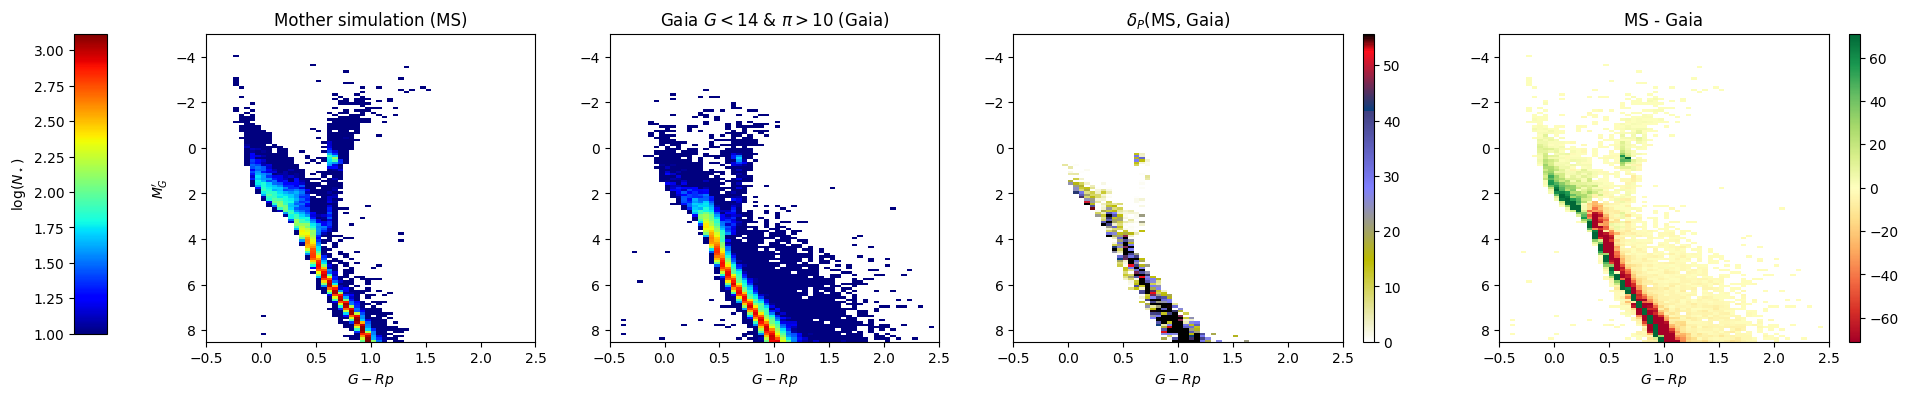


Distance between catalogs: 16797.967517



In [13]:
thresh = 10
distance_cmd, difference_cmd, quotient_cmd = generate_difference_hess_diagram(catalog_cmd_ms, catalog_cmd_Gaia, thresh)
build_hess_diagrams_plots(catalog_cmd_ms, catalog_cmd_Gaia, distance_cmd, difference_cmd, thresh, titles=['Mother simulation (MS)', r'Gaia $G<14$ & $\pi>10$ (Gaia)', r'$\delta_P$(MS, Gaia)', 'MS - Gaia'])
distance = compute_distance(catalog_data_Gaia, catalog_data_ms, thresh)

#### Define mother simulation parameters

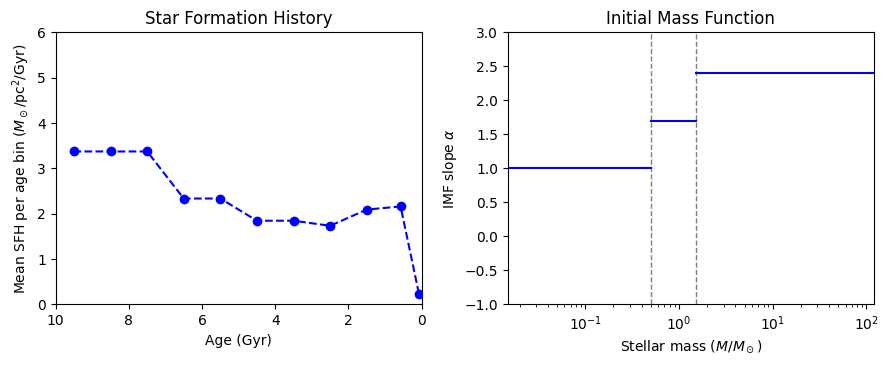

In [24]:
alpha1_ms, alpha2_ms, alpha3_ms = 1.0, 1.7, 2.4
imf_params_ms = np.array([alpha1_ms, alpha2_ms, alpha3_ms])
imf_ranges = np.array([0.015, 0.5, 1.53, 120])
SigmaParam_ms = np.array([0.23849939, 2.16065876, 2.09126259, 1.73444126, 3.69141129, 4.67037177, 10.11851605])
SigmaBFParam_ms = define_SigmaBFParam(SigmaParam_ms)
tau_values = np.array([0.15/2, 0.15+0.85/2, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5])
K1_ms, K2_ms, K3_ms = Continuity_Coeficients_func(alpha1_ms, alpha2_ms, alpha3_ms)
bin_nor_ms = bin_nor_func(K1_ms, K2_ms, K3_ms, alpha1_ms, alpha2_ms, alpha3_ms, SigmaParam_ms)
build_sfh_imf(tau_values, SigmaBFParam_ms, imf_ranges, imf_params_ms, output=False, show=True, sfh_limits=[0, 6], imf_limits=[-1, 3])

#### Generate mother simulation CMD using BGM FASt

In [15]:
acc, simple = accumulators_init(sc, MatrixAccumulatorParam)[:2]
catalog_BGM.foreach(lambda x: wpes_func(x, K1_ms, K2_ms, K3_ms, alpha1_ms, alpha2_ms, alpha3_ms, SigmaBFParam_ms, bin_nor_ms, K1_ms, K2_ms, K3_ms, alpha1_ms, alpha2_ms, alpha3_ms, SigmaBFParam_ms, bin_nor_ms, acc))
catalog_cmd_MS, catalog_data_MS = return_cmd(acc)

#### Compute distance and difference between Gaia and mother simulation CMDs

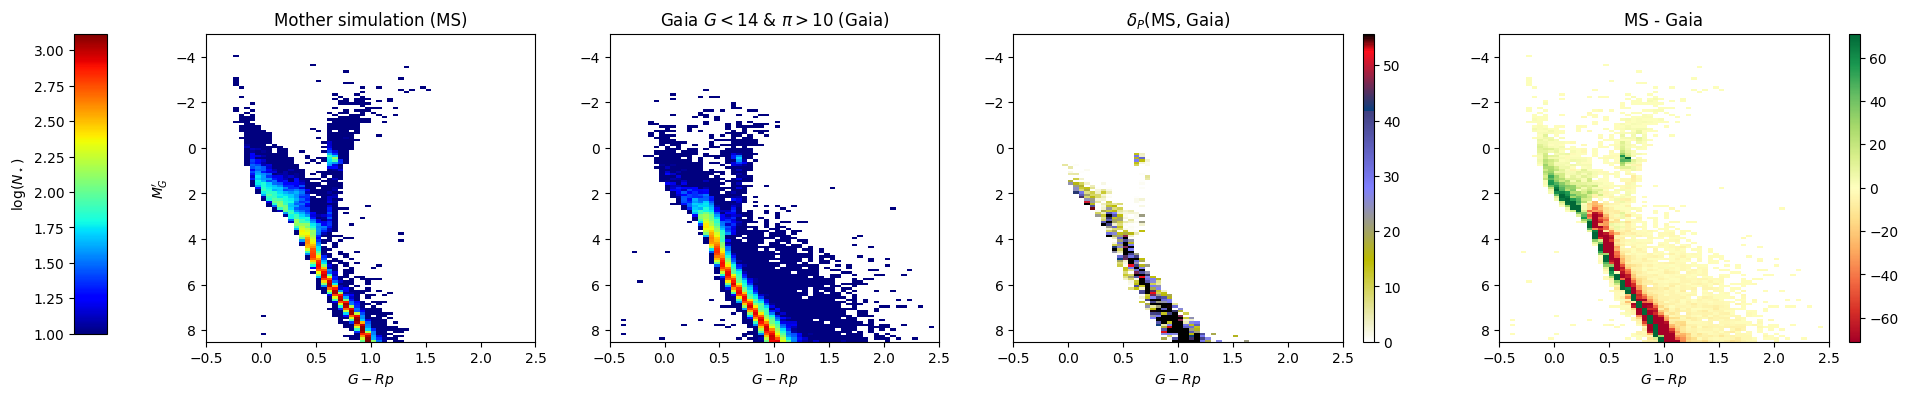


Distance between catalogs: 16797.967517



In [16]:
thresh = 10
distance_cmd, difference_cmd, quotient_cmd = generate_difference_hess_diagram(catalog_cmd_MS, catalog_cmd_Gaia, thresh)
build_hess_diagrams_plots(catalog_cmd_MS, catalog_cmd_Gaia, distance_cmd, difference_cmd, thresh, titles=['Mother simulation (MS)', r'Gaia $G<14$ & $\pi>10$ (Gaia)', r'$\delta_P$(MS, Gaia)', 'MS - Gaia'])
distance = compute_distance(catalog_data_Gaia, catalog_data_MS, thresh)

### Run BGM FASt - compare Gaia and BGM FASt pseudo-simulation

#### Define BGM FASt parameters from del Alcázar-Julià et al. 2025

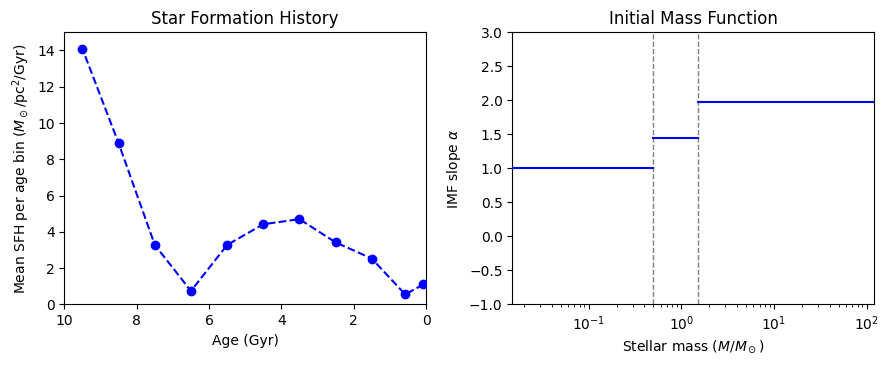

In [25]:
alpha1_ps, alpha2_ps, alpha3_ps = 1.0, 1.45, 1.98
imf_params_ps = np.array([alpha1_ps, alpha2_ps, alpha3_ps])
imf_ranges = np.array([0.015, 0.5, 1.53, 120])
tau_values = np.array([0.15/2, 0.15+0.85/2, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5])
SigmaBFParam_ps = np.array([1.10, 0.55, 2.53, 3.42, 4.70, 4.42, 3.28, 0.74, 3.28, 8.88, 14.08])
SigmaParam_ps = recover_SigmaParam(SigmaBFParam_ps)
K1_ps, K2_ps, K3_ps = Continuity_Coeficients_func(alpha1_ps, alpha2_ps, alpha3_ps)
bin_nor_ps = bin_nor_func(K1_ps, K2_ps, K3_ps, alpha1_ps, alpha2_ps, alpha3_ps, SigmaParam_ps)
build_sfh_imf(tau_values, SigmaBFParam_ps, imf_ranges, imf_params_ps, output=False, show=True, sfh_limits=[0, 15], imf_limits=[-1, 3])

#### Generate BGM FASt CMD

In [18]:
acc, simple = accumulators_init(sc, MatrixAccumulatorParam)[:2]
catalog_BGM.foreach(lambda x: wpes_func(x, K1_ps, K2_ps, K3_ps, alpha1_ps, alpha2_ps, alpha3_ps, SigmaBFParam_ps, bin_nor_ps, K1_ms, K2_ms, K3_ms, alpha1_ms, alpha2_ms, alpha3_ms, SigmaBFParam_ms, bin_nor_ms, acc))
catalog_cmd_BGM, catalog_data_BGM = return_cmd(acc)

#### Compute distance and difference between Gaia and BGM FASt CMDs

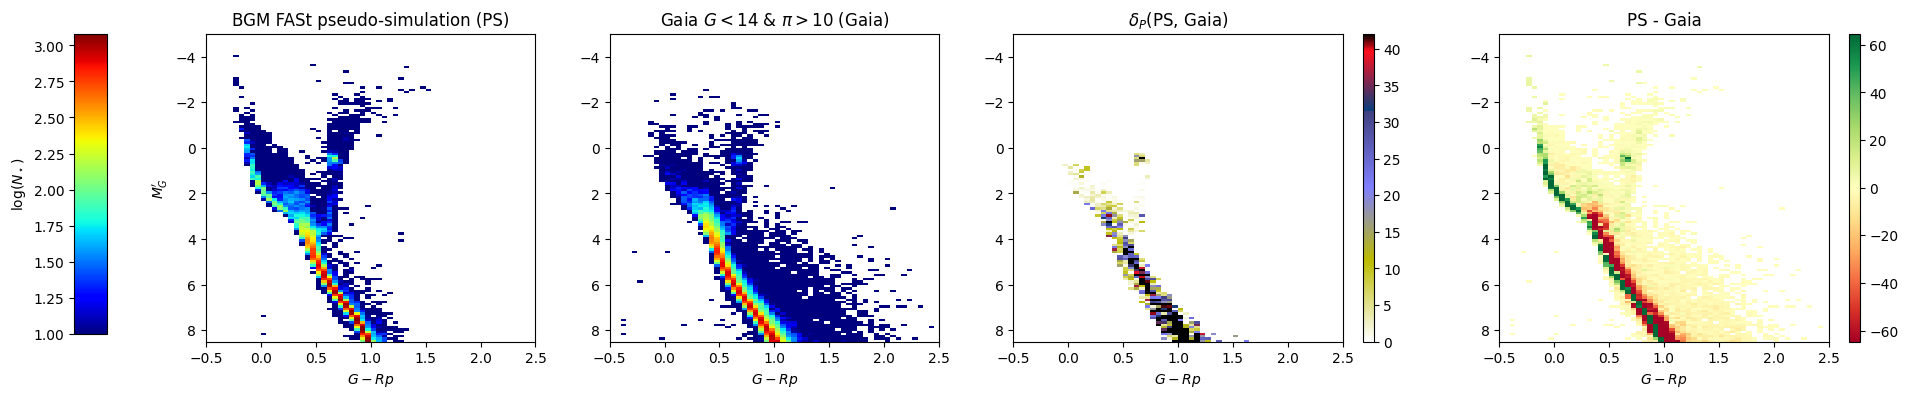


Distance between catalogs: 12577.165892



In [20]:
thresh = 10
distance_cmd, difference_cmd, quotient_cmd = generate_difference_hess_diagram(catalog_cmd_BGM, catalog_cmd_Gaia, thresh)
build_hess_diagrams_plots(catalog_cmd_BGM, catalog_cmd_Gaia, distance_cmd, difference_cmd, thresh, titles=['BGM FASt pseudo-simulation (PS)', r'Gaia $G<14$ & $\pi>10$ (Gaia)', r'$\delta_P$(PS, Gaia)', 'PS - Gaia'])
distance = compute_distance(catalog_data_Gaia, catalog_data_BGM, thresh)